In this experiment, using Split Conformal Prediction, we want to analyze the following:

1.   How different can be $\mathcal{D}_{\text{train}}$ and $\mathcal{D}_{\text{calib}}$?
2.   How much variation can $\mathcal{D}_{\text{calib}}$ take? Add Gaussian noise to assess it.

1.   What partitions of a finite set works?
2.   Evaluate Coverage and Prediction Set Size.

1.   APS vs SCP is implemented as recalibrating/or not in the last loop.


In [ ]:
!pip install timm torchvision matplotlib -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 24.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
#from tensorflow.keras.datasets import mnist
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import torchvision.transforms.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.nn.functional import softmax
from torch.utils.data import random_split
import torch.nn as nn
from tqdm import tqdm
import math
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from captum.attr import LRP
from captum.attr import visualization as viz
import networkx as nx
import plotly.graph_objects as go

In [ ]:
#Alternative as MNIST original link keeps failing...
transform = transforms.Compose([transforms.ToTensor()])

mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

X = mnist.data.numpy().reshape(-1, 784) / 255.0
y = mnist.targets.numpy()

y = y.astype(int)

len(X)

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 9.91M/9.91M [00:00<00:00, 48.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 28.9k/28.9k [00:00<00:00, 3.33MB/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 1.65M/1.65M [00:00<00:00, 14.8MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 404: Not Found



100%|██████████| 4.54k/4.54k [00:00<00:00, 5.71MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



60000

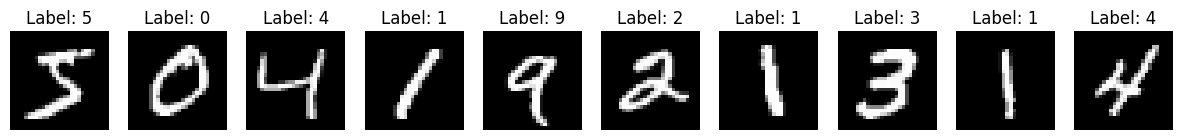

In [ ]:
# Display of the first 10 images
fig, axes = plt.subplots(1, 10, figsize=(15, 3))
for i, ax in enumerate(axes):
    ax.imshow(X[i].reshape(28, 28), cmap='gray')
    ax.axis('off')
    ax.set_title(f"Label: {y[i]}")
plt.show()

### MLP

In [ ]:
# Splitting dataset randomly into Training (D_Train) and Calibration (D_Calib)
# 70% for training, 30% for calibration
X_train, X_calib, y_train, y_calib = train_test_split(X, y, test_size=0.3, random_state=42)

In [ ]:
# Model is a simple MLP classifier (Multilayer Perceptron)
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter=20, random_state=42)
clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(max_iter=20, random_state=42)

In [ ]:
# Function to calculate accuracy
def compute_accuracy(X, y, model):
    y_pred = model.predict(X)
    return accuracy_score(y, y_pred)

original_accuracy = compute_accuracy(X_calib, y_calib, clf)
print(f"Original accuracy on calibration set: {original_accuracy}")

Original accuracy on calibration set: 0.9727222222222223


In [ ]:
!pip install innvestigate scikit-learn -q
!pip install captum -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.9/840.9 kB 9.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 489.9/489.9 MB 827.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 41.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 49.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 4.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-text 2.18.1 requires tensorflow<2.19,>=2.18.0, but you have tensorflow 2.14.1 which is incompatible.
tf-keras 2.18.0 requires tensorflow<2.19

### NN - LRP

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)   # Sin stride (mantiene 28x28)
        self.conv2 = nn.Conv2d(16, 16, kernel_size=3, padding=1, stride=2)  # Stride solo aquí (reduce a 14x14)
        self.fc1 = nn.Linear(16 * 14 * 14, 60)  # Ajustar tamaño de entrada
        self.fc2 = nn.Linear(60, 10)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))  # 28x28x16
        x = self.relu(self.conv2(x))  # 14x14x16 (stride=2)
        x = x.view(x.size(0), -1)  # Aplanar a (batch, 16*14*14)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Filter dataset for only digits 1 and 9
def filter_digits(dataset, digits=[1, 9]):
    filtered_indices = [i for i, label in enumerate(dataset.targets) if label in digits]
    filtered_dataset = torch.utils.data.Subset(dataset, filtered_indices)
    return filtered_dataset

transform = transforms.Compose([transforms.ToTensor()])

train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=transform, download=True)

# Filter for only 1 and 9
train_dataset = filter_digits(train_dataset, digits=[1, 9])
test_dataset = filter_digits(test_dataset, digits=[1, 9])

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

# Initialize model, loss, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train model (for demonstration, we train for 1 epoch)
def train_model(model, train_loader, optimizer, criterion, epochs=1):
    model.train()
    for epoch in range(epochs):
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


In [ ]:
# Uncomment the following line to train the model
train_model(model, DataLoader(train_dataset, batch_size=64, shuffle=True), optimizer, criterion, epochs=1)

Epoch [1/1], Loss: 0.0008


In [ ]:
def compute_accuracy(model, dataloader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
    return correct / total

accuracy = compute_accuracy(model, test_loader)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Test Accuracy: 99.63%


In [ ]:
# Load pretrained model (if available)
try:
    model.load_state_dict(torch.load("mnist_cnn.pth"))
    print("Loaded pretrained model.")
except:
    print("Training model...")
    train_model(model, DataLoader(train_dataset, batch_size=64, shuffle=True), optimizer, criterion, epochs=1)
    torch.save(model.state_dict(), "mnist_cnn.pth")

# Function to get LRP attributions
def get_lrp_attributions(image, model):
    image = image.unsqueeze(0)  # Ensure the image has a batch dimension
    output = model(image)
    predicted_label = torch.argmax(output, dim=1).item()

    # Apply LRP
    lrp = LRP(model)
    attributions = lrp.attribute(image, target=predicted_label)
    return attributions, predicted_label

Training model...


<ipython-input-43-5df669f29cb6>:3: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



Epoch [1/1], Loss: 0.0544


/usr/local/lib/python3.11/dist-packages/captum/_utils/gradient.py:57: UserWarning:

Input Tensor 0 did not already require gradients, required_grads has been set automatically.



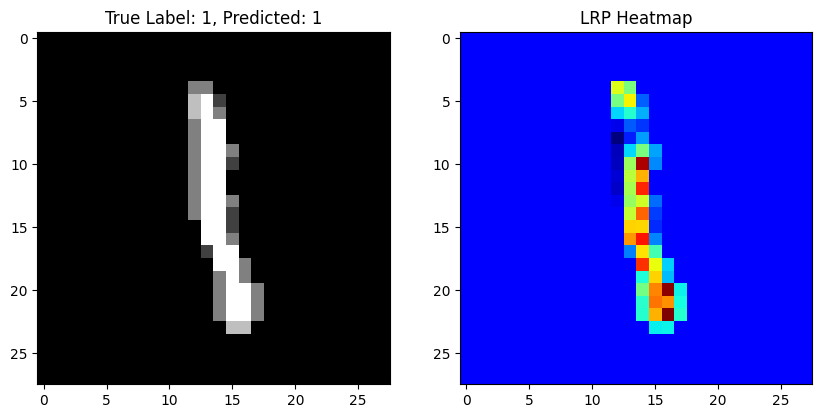

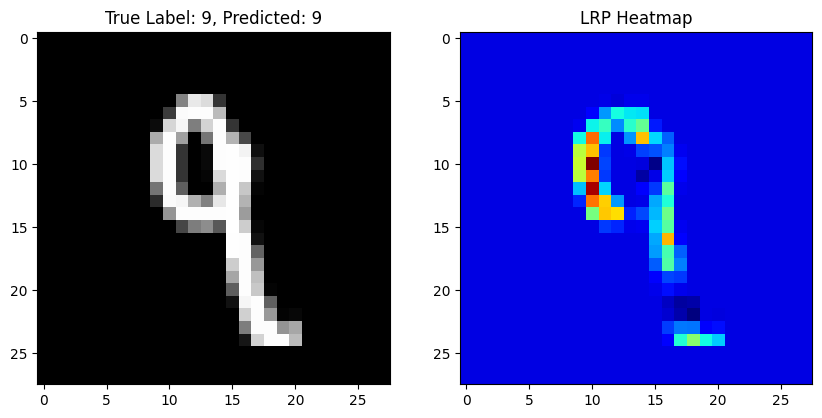

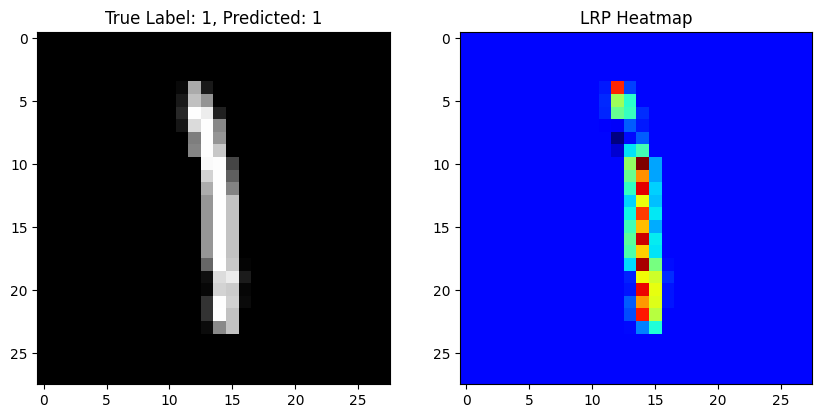

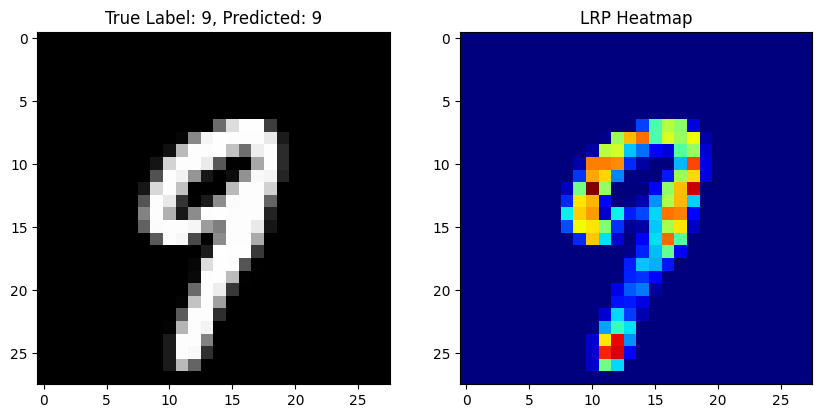

In [ ]:
# Select and visualize 3 random images and their corresponding LRP heatmaps
for i, (image, label) in enumerate(test_loader):
    if i == 4:  # Stop after 3 images
        break

    # Ensure the image is in the correct shape [batch_size, channels, height, width]
    image = image.squeeze(0)  # Remove the extra batch dimension if it's a single image

    # Get LRP attributions
    attributions, predicted_label = get_lrp_attributions(image, model)

    # Visualization
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(image.squeeze().cpu().numpy(), cmap="gray")
    ax[0].set_title(f"True Label: {label.item()}, Predicted: {predicted_label}")

    # Detach and convert the attributions to numpy for visualization
    ax[1].imshow(attributions.squeeze().detach().cpu().numpy(), cmap="jet")
    ax[1].set_title(f"LRP Heatmap")

    plt.show()

In [ ]:
def summarize_model_layers(model):
    """
    Provide a summary of layers and their neuron/parameter counts
    """
    print("\n--- Model Layer Summary ---")

    # Convolutional Layers
    print(f"Conv1 Layer:")
    print(f"  Input Channels: {model.conv1.in_channels}")
    print(f"  Output Channels (Neurons): {model.conv1.out_channels}")
    print(f"  Kernel Size: {model.conv1.kernel_size}")

    print(f"\nConv2 Layer:")
    print(f"  Input Channels: {model.conv2.in_channels}")
    print(f"  Output Channels (Neurons): {model.conv2.out_channels}")
    print(f"  Kernel Size: {model.conv2.kernel_size}")

    # Fully Connected Layers
    print(f"\nFC1 Layer:")
    print(f"  Input Features: {model.fc1.in_features}")
    print(f"  Output Neurons: {model.fc1.out_features}")

    print(f"\nFC2 Layer (Output Layer):")
    print(f"  Input Features: {model.fc2.in_features}")
    print(f"  Output Neurons (Classes): {model.fc2.out_features}")

    # Total parameter count
    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"\nTotal Trainable Parameters: {count_parameters(model):,}")

#summarize_model_layers(model)

In [ ]:
def create_per_image_neuron_dataframes(model, test_loader, num_images=10):
    """
    Create comprehensive DataFrames of neuron activations and connections for each image

    Args:
        model (nn.Module): Neural network model
        test_loader (DataLoader): Test data loader
        num_images (int): Number of images to process

    Returns:
        list: List of dictionaries containing DataFrames for each image
    """
    model.eval()
    all_images_data = []

    with torch.no_grad():
        for img_idx, (image, label) in enumerate(test_loader):
            if img_idx >= num_images:
                break

            # Prepare image
            image = image.to(device)

            # Activation and connection storage
            neuron_data = {
                'conv1': {'activations': [], 'connections': []},
                'conv2': {'activations': [], 'connections': []},
                'fc1':   {'activations': [], 'connections': []},
                'fc2':   {'activations': [], 'connections': []}
            }

            # Hooks to capture layer details
            def create_hook(layer_name):
                def hook(module, input, output):
                    # Capture activations
                    if len(output.shape) == 4:  # Convolutional layer
                        # Flatten channel activations
                        activations = output.permute(1, 0, 2, 3).reshape(output.shape[1], -1).mean(dim=1)
                        neuron_data[layer_name]['activations'] = activations.cpu().numpy()

                        # Capture weights as connections
                        weights = module.weight.data.cpu().numpy()
                        neuron_data[layer_name]['connections'] = weights.reshape(weights.shape[0], -1)

                    elif len(output.shape) == 2:  # Fully connected layer
                        neuron_data[layer_name]['activations'] = output.cpu().numpy()[0]

                        # Capture weights as connections
                        weights = module.weight.data.cpu().numpy()
                        neuron_data[layer_name]['connections'] = weights
                return hook

            # Register hooks
            hooks = [
                model.conv1.register_forward_hook(create_hook('conv1')),
                model.conv2.register_forward_hook(create_hook('conv2')),
                model.fc1.register_forward_hook(create_hook('fc1')),
                model.fc2.register_forward_hook(create_hook('fc2'))
            ]

            # Forward pass
            output = model(image)

            # Remove hooks
            for hook in hooks:
                hook.remove()

            # Prepare image-specific DataFrames
            image_dataframes = {
                'image_index': img_idx,
                'true_label': label.item(),
                'predicted_label': torch.argmax(output, dim=1).item(),
                'dataframes': {}
            }

            # Create DataFrame for each layer's activations and connections
            for layer, data in neuron_data.items():
                # Activation DataFrame
                act_df = pd.DataFrame({
                    'layer': layer,
                    'neuron_index': range(len(data['activations'])),
                    'activation_value': data['activations']
                })

                # Connection DataFrame
                if len(data['connections'].shape) == 2:
                    conn_df = pd.DataFrame(data['connections'])
                    conn_df['layer'] = layer
                    conn_df['neuron_index'] = range(conn_df.shape[0])

                # Store DataFrames
                image_dataframes['dataframes'][f'{layer}_activations'] = act_df
                image_dataframes['dataframes'][f'{layer}_connections'] = conn_df

            # Add to list of image data
            all_images_data.append(image_dataframes)

    return all_images_data

# Run the analysis
per_image_neuron_data = create_per_image_neuron_dataframes(model, test_loader)

per_image_neuron_data[0]

{'image_index': 0,
 'true_label': 1,
 'predicted_label': 1,
 'dataframes': {'conv1_activations':     layer  neuron_index  activation_value
  0   conv1             0          0.362543
  1   conv1             1          0.347136
  2   conv1             2          0.154901
  3   conv1             3          0.090302
  4   conv1             4          0.160147
  5   conv1             5          0.258511
  6   conv1             6          0.025814
  7   conv1             7          0.376921
  8   conv1             8          0.182516
  9   conv1             9          0.182259
  10  conv1            10          0.160326
  11  conv1            11          0.252715
  12  conv1            12          0.014187
  13  conv1            13          0.150744
  14  conv1            14         -0.014882
  15  conv1            15          0.036231,
  'conv1_connections':            0         1         2         3         4         5         6  \
  0   0.400412  0.399371  0.071231 -0.067315  0.237489  0

In [ ]:
per_image_neuron_data[3]['dataframes']['conv2_activations']

,layer,neuron_index,activation_value
0,conv2,0,0.070487
1,conv2,1,0.445887
2,conv2,2,0.160948
3,conv2,3,0.557783
4,conv2,4,-0.166093
5,conv2,5,-0.234721
6,conv2,6,0.333487
7,conv2,7,0.272461
8,conv2,8,0.156724
9,conv2,9,0.061776


In [ ]:
per_image_neuron_data[3]['dataframes']['conv2_connections']

,0,1,2,3,4,5,6,7,8,9,...,136,137,138,139,140,141,142,143,layer,neuron_index
0,0.053389,0.023715,-0.082655,-0.048249,-0.076035,-0.150770,0.021789,0.087136,0.136641,0.125749,...,0.105212,0.008460,0.086248,-0.005925,-0.033853,0.113257,-0.040305,0.088088,conv2,0
1,0.047589,-0.093007,0.005160,0.069936,0.136776,0.046387,0.010860,0.068729,-0.004232,-0.004889,...,0.075859,0.051621,0.013238,0.045813,0.091032,0.005281,-0.026384,0.078543,conv2,1
2,0.058461,0.100847,-0.038368,0.022629,0.103998,-0.064163,-0.030390,-0.050265,0.004671,0.000319,...,0.094657,0.007707,0.022765,0.004527,0.002996,0.085109,0.008654,0.067731,conv2,2
3,-0.035365,0.023469,0.107092,0.101842,0.143467,0.217515,-0.012316,0.084479,0.127317,-0.104037,...,0.000802,0.089539,-0.032844,0.050453,-0.007134,0.030011,-0.008236,-0.030027,conv2,3
4,0.062249,-0.131436,-0.046978,0.021597,-0.080085,-0.078712,-0.103583,0.048199,0.034387,-0.074277,...,0.045809,-0.082850,0.027167,-0.046521,0.067527,-0.041539,0.057837,0.032542,conv2,4
5,-0.019309,-0.080785,0.035847,0.020273,0.009665,0.035786,-0.006190,-0.040837,-0.020941,0.074329,...,-0.027615,-0.036336,-0.055786,0.008235,-0.075360,-0.063744,0.026530,0.010399,conv2,5
6,0.049547,0.038741,-0.036449,-0.002058,0.041931,0.053819,-0.005733,-0.068649,-0.066126,-0.024237,...,0.095926,0.090875,-0.025141,0.018905,0.031970,-0.055053,0.091992,-0.061894,conv2,6
7,-0.152914,-0.041600,0.115807,-0.041148,-0.039541,0.071635,-0.011336,0.034141,0.078109,-0.036853,...,0.086062,-0.007312,0.005437,0.073091,0.030808,-0.011768,0.093748,0.089395,conv2,7
8,0.125563,0.033356,-0.048423,0.110720,-0.018201,-0.147717,-0.042072,0.026514,-0.127686,-0.001961,...,0.017386,-0.016188,0.018640,0.010524,-0.089284,0.094356,0.033373,0.012280,conv2,8
9,-0.068213,-0.115001,-0.004743,-0.028494,-0.027653,0.079632,0.049930,-0.042845,0.092674,0.078472,...,-0.005325,0.106815,0.014020,-0.074019,0.011533,-0.078723,0.016492,-0.013510,conv2,9


In [ ]:
# Display results for each image
for image_data in per_image_neuron_data:
    print(f"\n--- Image {image_data['image_index']} ---")
    print(f"True Label: {image_data['true_label']}")
    print(f"Predicted Label: {image_data['predicted_label']}")

    # Display DataFrames for this image
    for df_name, df in image_data['dataframes'].items():
        print(f"\n{df_name.upper()} DataFrame:")
        print(df)
        print("\n" + "="*50)


--- Image 0 ---
True Label: 1
Predicted Label: 1

CONV1_ACTIVATIONS DataFrame:
    layer  neuron_index  activation_value
0   conv1             0          0.362543
1   conv1             1          0.347136
2   conv1             2          0.154901
3   conv1             3          0.090302
4   conv1             4          0.160147
5   conv1             5          0.258511
6   conv1             6          0.025814
7   conv1             7          0.376921
8   conv1             8          0.182516
9   conv1             9          0.182259
10  conv1            10          0.160326
11  conv1            11          0.252715
12  conv1            12          0.014187
13  conv1            13          0.150744
14  conv1            14         -0.014882
15  conv1            15          0.036231


CONV1_CONNECTIONS DataFrame:
           0         1         2         3         4         5         6  \
0   0.400412  0.399371  0.071231 -0.067315  0.237489  0.328836 -0.150906   
1   0.062670  0.420839 

## Network graphs

In [1]:
def visualizar_red_neuronal_interactiva(per_image_neuron_data, imagen_index=0):
    """
    Crea una visualización interactiva de la red neuronal con Plotly

    Args:
        per_image_neuron_data: Datos de activaciones y conexiones
        imagen_index: Índice de la imagen a visualizar

    Returns:
        figura de plotly interactiva
    """
    # Obtener datos de la imagen
    imagen_data = per_image_neuron_data[imagen_index]
    dfs = imagen_data['dataframes']

    # Crear grafo dirigido
    G = nx.DiGraph()

    # Estructura de capas
    capas = ['input', 'conv1', 'conv2', 'fc1', 'fc2', 'output']
    layer_positions = {capa: i for i, capa in enumerate(capas)}

    # Número de neuronas por capa (completo)
    neuron_counts = {
        'input': 1,
        'conv1': len(dfs['conv1_activations']),
        'conv2': len(dfs['conv2_activations']),
        'fc1': len(dfs['fc1_activations']),
        'fc2': len(dfs['fc2_activations']),
        'output': 1
    }

    # Posiciones de los nodos
    pos = {}
    node_colors = {}
    node_sizes = {}
    node_texts = {}

    # Añadir nodos para cada capa
    # Nodo de entrada
    G.add_node('input')
    pos['input'] = (0, 0)
    node_colors['input'] = 'rgba(200, 200, 200, 0.8)'
    node_sizes['input'] = 25
    node_texts['input'] = f"Imagen de entrada"

    # Nodos para capas ocultas
    for capa in ['conv1', 'conv2', 'fc1', 'fc2']:
        # Obtener número de neuronas
        num_neuronas = neuron_counts[capa]

        # Añadir cada neurona
        for i in range(num_neuronas):
            nodo_id = f"{capa}_{i}"
            G.add_node(nodo_id)

            # Calcular posición vertical (distribuir uniformemente)
            y_pos = (i - (num_neuronas - 1) / 2) * (10 / max(1, num_neuronas))
            pos[nodo_id] = (layer_positions[capa], y_pos)

            # Obtener valor de activación
            activacion = dfs[f'{capa}_activations'].iloc[i]['activation_value']

            # Color basado en activación (positiva: azul, negativa: rojo, cercana a cero: gris)
            if activacion > 0.1:
                intensidad = min(255, int(100 + 155 * activacion))
                node_colors[nodo_id] = f'rgba(0, 0, {intensidad}, 0.8)'
            elif activacion < -0.1:
                intensidad = min(255, int(100 + 155 * abs(activacion)))
                node_colors[nodo_id] = f'rgba({intensidad}, 0, 0, 0.8)'
            else:
                node_colors[nodo_id] = f'rgba(150, 150, 150, 0.8)'

            # Tamaño basado en la magnitud de la activación
            node_sizes[nodo_id] = 10 + 15 * abs(activacion)

            # Texto al pasar el ratón
            node_texts[nodo_id] = f"{capa} neurona {i}<br>Activación: {activacion:.4f}"

    # Nodo de salida
    G.add_node('output')
    pos['output'] = (layer_positions['output'], 0)
    node_colors['output'] = 'rgba(0, 200, 0, 0.8)'
    node_sizes['output'] = 25
    node_texts['output'] = f"Clase predicha: {imagen_data['predicted_label']}"

    # Añadir conexiones entre capas
    edge_x = []
    edge_y = []
    edge_colors = []
    edge_widths = []
    edge_texts = []

    # Conectar input a conv1
    for i in range(neuron_counts['conv1']):
        G.add_edge('input', f'conv1_{i}')
        x0, y0 = pos['input']
        x1, y1 = pos[f'conv1_{i}']
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_colors.append('rgba(100, 100, 100, 0.3)')
        edge_widths.append(1)
        edge_texts.append("Conexión entrada")

    # Conectar capas ocultas entre sí
    layer_pairs = [('conv1', 'conv2'), ('conv2', 'fc1'), ('fc1', 'fc2')]
    for capa1, capa2 in layer_pairs:
        # Limitar conexiones para visualización
        max_display = min(3000, neuron_counts[capa1] * neuron_counts[capa2])
        connections_shown = 0

        for i in range(min(neuron_counts[capa1], 20)):
            for j in range(min(neuron_counts[capa2], 20)):
                if connections_shown >= max_display:
                    break

                # Intentar obtener peso de la conexión
                try:
                    peso = dfs[f'{capa1}_connections'].iloc[i][j]

                    # Solo mostrar conexiones significativas
                    if abs(peso) > 0.001:
                        G.add_edge(f"{capa1}_{i}", f"{capa2}_{j}")

                        x0, y0 = pos[f"{capa1}_{i}"]
                        x1, y1 = pos[f"{capa2}_{j}"]

                        edge_x.extend([x0, x1, None])
                        edge_y.extend([y0, y1, None])

                        # Color basado en el peso (positivo: azul, negativo: rojo)
                        if peso > 0:
                            edge_colors.append(f'rgba(0, 0, 255, {min(0.8, 0.1 + abs(peso))})')
                        else:
                            edge_colors.append(f'rgba(255, 0, 0, {min(0.8, 0.1 + abs(peso))})')

                        # Grosor basado en la magnitud del peso
                        edge_widths.append(max(0.5, min(3, abs(peso) * 3)))

                        # Texto al pasar el ratón
                        edge_texts.append(f"Peso: {peso:.4f}")

                        connections_shown += 1
                except:
                    pass

            if connections_shown >= max_display:
                break

    # Conectar fc2 a output
    for i in range(neuron_counts['fc2']):
        G.add_edge(f'fc2_{i}', 'output')
        x0, y0 = pos[f'fc2_{i}']
        x1, y1 = pos['output']
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])

        # Intentar obtener peso para la clase predicha
        try:
            peso = dfs['fc2_connections'].iloc[i][imagen_data['predicted_label']]
            if peso > 0:
                edge_colors.append(f'rgba(0, 0, 255, {min(0.8, 0.3 + abs(peso))})')
            else:
                edge_colors.append(f'rgba(255, 0, 0, {min(0.8, 0.3 + abs(peso))})')
            edge_widths.append(max(1, min(4, abs(peso) * 3)))
            edge_texts.append(f"Peso: {peso:.4f}")
        except:
            edge_colors.append('rgba(100, 100, 100, 0.3)')
            edge_widths.append(1)
            edge_texts.append("Conexión a salida")

    # Create trazas para los bordes
    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        hoverinfo='text',
        mode='lines',
        line=dict(width=0.5),  # Remove color here
        marker=dict(color=edge_colors, size=edge_widths),  # Add colors and widths here
        text=edge_texts
    )

    # Crear trazas para los nodos
    node_x = []
    node_y = []
    node_color = []
    node_size = []
    node_text = []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_color.append(node_colors[node])
        node_size.append(node_sizes[node])
        node_text.append(node_texts[node])

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=False,
            color=node_color,
            size=node_size,
            line_width=2,
            line=dict(color='white')
        ),
        text=node_text
    )

    # Añadir etiquetas de capas
    layer_annotations = []
    for capa, x_pos in layer_positions.items():
        layer_annotations.append(
            dict(
                x=x_pos,
                y=5,  # Posición encima de la red
                xref='x',
                yref='y',
                text=f"{capa.upper()}<br>({neuron_counts[capa]} neuronas)",
                showarrow=False,
                font=dict(size=14, color='black')
            )
        )

    # Crear figura
    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title=f"Red Neuronal - Imagen {imagen_index}<br>Etiqueta real: {imagen_data['true_label']}, Predicción: {imagen_data['predicted_label']}",
                        titlefont_size=16,
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20, l=5, r=5, t=40),
                        annotations=layer_annotations,
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        height=1000,
                        width=1600
                    ))

    # Añadir leyenda explicativa
    fig.add_annotation(
        x=1.02, y=0.5,
        xref='paper', yref='paper',
        text="<b>Leyenda:</b><br><br>" +
             "<b>Color de nodo:</b><br>" +
             "• <span style='color:blue'>Azul</span>: Activación positiva<br>" +
             "• <span style='color:red'>Rojo</span>: Activación negativa<br>" +
             "• <span style='color:gray'>Gris</span>: Activación cercana a cero<br><br>" +
             "<b>Tamaño de nodo:</b><br>" +
             "• Mayor tamaño = Mayor magnitud de activación<br><br>" +
             "<b>Color de conexión:</b><br>" +
             "• <span style='color:blue'>Azul</span>: Peso positivo<br>" +
             "• <span style='color:red'>Rojo</span>: Peso negativo<br><br>" +
             "<b>Grosor de conexión:</b><br>" +
             "• Mayor grosor = Mayor magnitud del peso",
        showarrow=False,
        align='left'
    )

    # Añadir explicación de activaciones negativas
    fig.add_annotation(
        x=1.02, y=0.05,
        xref='paper', yref='paper',
        text="<b>¿Por qué hay activaciones negativas?</b><br><br>" +
             "En redes neuronales, las activaciones negativas<br>" +
             "ocurren cuando el input a una neurona produce<br>" +
             "un valor negativo. Esto es común en capas con<br>" +
             "funciones de activación como ReLU, tanh o<br>" +
             "funciones lineales. Las activaciones negativas<br>" +
             "pueden indicar inhibición o respuesta contraria<br>" +
             "a ciertas características de entrada.",
        showarrow=False,
        align='left'
    )

    return fig


In [ ]:
fig = visualizar_red_neuronal_interactiva(per_image_neuron_data, imagen_index=5)
fig.show()

In [ ]:
fig = visualizar_red_neuronal_interactiva(per_image_neuron_data, imagen_index=8)
fig.show()

In [ ]:
fig = visualizar_red_neuronal_interactiva(per_image_neuron_data, imagen_index=2)
fig.show()

In [ ]:
fig = visualizar_red_neuronal_interactiva(per_image_neuron_data, imagen_index=1)
fig.show()

In [ ]:
stop here

SyntaxError: invalid syntax (<ipython-input-14-a96ba3aab008>, line 1)

## Resnet & Inception (Pretrained, timm)

In [ ]:
%%script false --no-raise-error

def setup_model(model_name):
    model = timm.create_model(model_name, pretrained=True)  # Check number of classes

    # Obtener el número de características de entrada para la capa final (dependiendo del modelo)
    in_features = model.fc.in_features if hasattr(model, 'fc') else model.head.fc.in_features

    # Modificar la capa final para que tenga 10 salidas (para 10 clases)
    if hasattr(model, 'fc'):
        model.fc = nn.Linear(in_features, 10)  # Ajuste para ResNet, Inception y otros modelos similares
    elif hasattr(model, 'head'):
        model.head.fc = nn.Linear(in_features, 10)  # Ajuste para modelos como EfficientNet
    else:
        raise ValueError("Unsupported model architecture")

    model.eval()
    return model

In [ ]:
def setup_model(model_name):
    model = timm.create_model(model_name, pretrained=True,num_classes=10)  # Simplyfied
    model.eval()
    return model

In [ ]:
# Loading here the trained models by Protim
def setup_model(model_name, checkpoint_path=None):
    model = timm.create_model(model_name, pretrained=False ,num_classes=10)  # Simplyfied

    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        model.load_state_dict(checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint)
        print(f"Checkpoint loaded: {checkpoint_path}")

    model.eval()
    return model

In [ ]:
def setup_model(model_name, checkpoint_path=None):
    model = timm.create_model(model_name, pretrained=False, num_classes=10)

    if checkpoint_path:
        checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
        state_dict = checkpoint['state_dict'] if 'state_dict' in checkpoint else checkpoint

        new_state_dict = {}
        for key in state_dict:
            new_key = key.replace('model.', '')
            new_state_dict[new_key] = state_dict[key]

        model.load_state_dict(new_state_dict)
        print(f"Checkpoint loaded: {checkpoint_path}")

    model.eval()
    return model

In [ ]:
def get_transforms():
    return transforms.Compose([
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # Replicate the single channel!
    ])

In [ ]:
from torchvision.transforms import Compose, ToTensor, Normalize

def get_transforms():
    return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.34433492, 0.38015251, 0.40769764), (0.20382567, 0.13680683, 0.11487552)),
            transforms.Resize((224,224)),
            transforms.ConvertImageDtype(torch.float32),
            ])

In [ ]:
from torchvision.datasets import EuroSAT
from torch.utils.data import random_split, Subset

### A first test to split the data and check the models... ###
transform = get_transforms()
full_dataset = datasets.EuroSAT(root='./data', download=True, transform=transform)
#full_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
#MNIST(root='./data', train=False, download=True, transform=transform)

indices = torch.randperm(len(full_dataset)).tolist()
subset_size = int(0.02 * len(full_dataset))
subset_indices = indices[:subset_size]

# Get subsample
subset = Subset(full_dataset, subset_indices)
#############################################

calib_percentage = 0.5  # 50% for Calibration

# Subset sizes
calib_size = math.floor(calib_percentage * len(subset))
test_size = len(subset) - calib_size

# Data splitting: calibration and test
calib_dataset, test_dataset = random_split(subset, [calib_size, test_size])

# DataLoaders
calib_dataloader = DataLoader(calib_dataset, batch_size=25) #100, probably should be smaller...
test_dataloader  = DataLoader(test_dataset, batch_size=25)

subset_labels = {full_dataset.targets[i] for i in subset_indices}
print(subset_labels)

In [ ]:
def show_images(dataloader, num_images=10):
    images, labels = next(iter(dataloader))  # Get the first batch of images and labels
    fig, axes = plt.subplots(1, num_images, figsize=(15, 3))

    for i in range(num_images):
        img = images[i]
        img = F.to_pil_image(img)  # Convert to PIL image

        axes[i].imshow(img, cmap="gray")  # Ensure grayscale display
        axes[i].axis("off")
        axes[i].set_title(f"Label: {labels[i].item()}")

    plt.show()

show_images(test_dataloader, num_images=10)

In [ ]:
# Around 4 mins

def get_predictions(model, dataloader):
    predictions = []
    with torch.no_grad():
        for images, _ in tqdm(dataloader, desc="Progress", unit="batch"):
            outputs = model(images)
            probs = torch.nn.functional.softmax(outputs, dim=1)
            predictions.append(probs.numpy())
    return np.concatenate(predictions)

# Testing models outputs
inception_v3_model = setup_model('inception_v3', '/content/drive/MyDrive/protim_checkpoints/inceptionv3_Checkpoint epoch=29-train_acc=1.00-train_loss=0.000-val_acc=0.98.ckpt')
inception_preds = get_predictions(inception_v3_model, test_dataloader)
print("Inception predictions shape:", inception_preds.shape)

resnet50_model = setup_model('resnet50', '/content/drive/MyDrive/protim_checkpoints/resnet_50_Checkpoint epoch=119-train_acc=0.94-train_loss=0.028-val_acc=0.95.ckpt')
resnet_preds = get_predictions(resnet50_model, test_dataloader)
print("ResNet predictions shape:", resnet_preds.shape)

In [ ]:
def compute_model_accuracy(predictions, true_labels):
    predicted_labels = np.argmax(predictions, axis=1)
    accuracy = np.mean(predicted_labels == true_labels)
    return accuracy

# Extrating labels for each image
true_labels = np.array([target for _, target in test_dataset])

inception_accuracy = compute_model_accuracy(inception_preds, true_labels)
print(f"Inception Accuracy: {inception_accuracy}")

resnet_accuracy = compute_model_accuracy(resnet_preds, true_labels)
print(f"ResNet Accuracy: {resnet_accuracy}")

In [ ]:
images, labels = next(iter(test_dataloader))
print("Shape of images:", images.shape)
print("Labels:", labels)

In [ ]:
unique_labels = np.unique(np.array([target for _, target in calib_dataset]))
unique_labels

In [ ]:
inception_preds.shape

In [ ]:
## CHECK ACCURACY OF TIMM MODELS